<h1><center> Capstone (Week5): The Battle of Neighborhoods in Houston  </center></h1>
<h2><center> Capstone Project for IBM Data Science Professional Certificate </center></h2>
<h3><center> Wenjun Hu, 02/13/2020 </center></h2>

<img src="https://communityimpact.com/wp-content/uploads/2019/09/skyline-houston.jpg" title="Houston"/>

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [References](#ref)
* [Supplemental Material](#supp)

## Introduction <a name="introduction"></a>

_**Houston**_ is the fourth most populous city in the USA, located in the state of Texas with the population more than 2.3 million. It is recognized worldwide for its oil and natural gas industry and biomedical research, such as the MD Anderson Cancer Center, as well as the famous National Aeronautics and Space Administration (NASA). [[1](#1)] Besides, Houston is a kid-friendly city with the Houston zoo, many beatiful parks, and different kinds of museums. One more reason that I like to live in Houston is that there are many restaurants and anyone can find his/her prefered ones in this city. So for this big city, how to find useful neighborhoods? Or if someone wants to start a business, such as staring a restaurant, in Houston, how to choose the suitable location?

### Business Problem
In this project, I will study the neighborhoods in Houston, especially the restaurants. I will try to find the popular restaurants and possible candidate locations for opening a restaurant. Since there are many restaurants aready in Houston, my goal will be to detect the locations that are not crowded with some kind of restaurants. Particularly, the location that has no that kind of restaurants will be most candidate. But the population should be another element that should be considered. I will use the neighborhood data to generate most promissing neighborhoods as the candidates based on the above criteria. Also I will clearly discuss the advantages and disadvantages of each candidates, so the stakeholders can choose the best possible locations.

### Target Audience
This project can benefit to people who want to open a restaurant business in Houston. Also, this project can have some suggestions for the running restaurants to better organize their business, such as continuing or expending current restaurant or shifting to another cuisine.

## Data <a name="data"></a>

The required data include:
+ List of all the neighborhoods in Houston
+ The locations for each neighborhood
+ The population data for each neighborhood
+ The list of all the restaurants in Houston

### Data Sources
+ The super neighborhoods can be found from the website https://cohgis-mycity.opendata.arcgis.com/datasets/coh-super-neighborhoods?geometry=-97.372%2C29.406%2C-93.458%2C30.240&page=9 [[2](#2)]

+ The locations of latitude and longitude for each super neighborhood can be obtained from Google through libary "_geopy.geocoders_".

+ The population data of each super neighborhood can be grabed from a pdf file from the website http://www.houstontx.gov/planning/Demographics/docs_pdfs/SN/Age_Total_Population.pdf [[3](#3)]

+ The list of all the restaurants for each super neighborhood can be obtained by using Foursquare API https://developer.foursquare.com [[4](#4)]

### How the data will be used to solve the problem?
First of all, the super neighborhoods will be grabbed from the website of "cohgis-mycity.opendata.arcgis.com". Then the locations of latitudes and longitudes will be obtained by "geopy.geocoders" from Google. Together with the population data of each super neighborhood, a dataframe will be created. After these pre-processing, I will use the Foursquare API to get all venues for each super neighborhood, for which I will select all the venues with category containing "Restaurant". By using the K-means clustering, I will analyze all restaurants in Houston and make the Houston map to visulize the locations of different clusters. Through these analysis, I can have clear idea for the candidate locations where to open a new restaurant business.

### Import Libary

In [37]:
import pandas as pd
import numpy as np
import requests
import csv
import folium
import tabula
import json
import geopandas as gpd
import os
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [38]:
# https://cohgis-mycity.opendata.arcgis.com/datasets/coh-super-neighborhoods?geometry=-97.372%2C29.406%2C-93.458%2C30.240&page=9
df=pd.read_csv('houston.csv')

In [36]:
# http://www.houstontx.gov/planning/Demographics/docs_pdfs/SN/Age_Total_Population.pdf

In [39]:
df.head()

,id,PERIMETER,POLYID,SNBNAME,GLOBALID,cohgisCOHGISSNBRAREA,cohgisCOHGISSNBRLEN,COUNCIL_ACTIVE,RECOGNITION_DATE,SnbrInfoURL,WeCan,Top10,CEA_FLAG,Shapearea,Shapelen
0,1,16572.025,60,FOURTH,{EDCA8617-F41A-4E57-8138-02BFCD50E562},0,0,NaN,NaN,http://www.houstontx.gov/superneighborhoods/60...,Y,NaN,N,1.296982e+07,16572.02602
1,2,43118.770,63,SECOND WARD,{C63DC59F-5080-4032-A84F-1660573E8BAA},0,0,Yes,2008-05-13T00:00:00.000Z,http://www.houstontx.gov/superneighborhoods/63...,Y,Y,Y,8.040472e+07,43118.77002
2,3,39256.388,61,DOWNTOWN,{F179E140-1B23-4A05-87A3-6BBBE0E510FF},0,0,NaN,NaN,http://www.houstontx.gov/superneighborhoods/61...,NaN,NaN,N,7.550023e+07,39256.38749
3,4,59784.698,59,CLINTON PARK,{F9FD0790-5903-444B-8485-8A18A7C14755},0,0,Yes,2000-11-20T00:00:00.000Z,http://www.houstontx.gov/superneighborhoods/59...,Y,NaN,Y,7.655352e+07,59784.69773
4,5,75759.390,21,UPTOWN,{5E8656DA-5291-4C40-B7D9-0C8D7F3A2D27},0,0,NaN,NaN,http://www.houstontx.gov/superneighborhoods/21...,NaN,NaN,N,2.297921e+08,75759.39014


### Setup ID and secret of Foursquare

In [40]:
CLIENT_ID = '5WPVN0YFGC1NMY4PZX03J2CHM1HHKIJNBGMOTBHFHWG2G4UC'
CLIENT_SECRET = '3EUWS4GX2LR1VMPGVAL2GUOLOT1YANVEKZNZOSBABGN3UQOU'
VERSION = '20200207'

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 5WPVN0YFGC1NMY4PZX03J2CHM1HHKIJNBGMOTBHFHWG2G4UC
CLIENT_SECRET:3EUWS4GX2LR1VMPGVAL2GUOLOT1YANVEKZNZOSBABGN3UQOU


** get the latitude and longitude of Houston from Foursquare **

In [41]:
city = 'Houston, USA'
geolocator = Nominatim(user_agent="foursquare_agent")
loc = geolocator.geocode(city)
lat_Houston = loc.latitude
lon_Houston = loc.longitude
print(city, lat_Houston, lon_Houston)

Houston, USA 29.7589382 -95.3676974


In [8]:
geolocator = Nominatim()
loc = geolocator.geocode(city)
print("latitude is :" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


latitude is : 29.7589382 
longtitude is:- -95.3676974


In [10]:
lats=[]
lons=[]
for i in df['SNBNAME']:
    nei=i+', Houston, TX'
    loc = geolocator.geocode(nei)
    lats.append(loc.latitude)
    lons.append(loc.longitude)
#     print(nei,lats[-1],lons[-1])

df_geo=pd.DataFrame([lats,lons])
df_geo=df_geo.T
df_geo.columns=['Latitude','Longitude']
houston_data= pd.concat([df['SNBNAME'], df_geo], axis=1)
houston_data.columns=['Neighborhood','Latitude','Longitude']
# # houston_data.to_csv('houston_nei.csv')

In [34]:
# for page in range(1,5):
#     pdffile='Age_Total_Population.pdf'
#     csvfile='csv/Age_Total_Population_'+str(page)+'.csv'
#     tabula.convert_into(pdffile, csvfile, output_format="csv", pages=page)

popu_data_1=pd.read_csv('csv/Age_Total_Population_1.csv')
popu_data_2=pd.read_csv('csv/Age_Total_Population_2.csv')
popu_data_3=pd.read_csv('csv/Age_Total_Population_3.csv')
popu_data_4=pd.read_csv('csv/Age_Total_Population_4.csv')
popu_data=pd.concat([popu_data_1,popu_data_2,popu_data_3,popu_data_4])
popu_data.dropna(inplace=True)
popu_data.head()

,SN #,Super Neighborhood Name,Total,Under 5 Years,5 to 17 Years,18 to 64 Years,Over 65 Years
0,1.0,Willowbrook,"5,804",232,930,"4,109",533
1,2.0,Greater Greenspoint,"41,618","5,885","8,735","25,674","1,326"
2,3.0,Carverdale,"4,916",270,"1,015","3,255",376
3,4.0,Fairbanks / Northwest Crossing,"16,541","1,743","2,830","11,104",864
4,5.0,Greater Inwood,"30,890","2,688","6,558","19,573","2,071"


In [35]:
houston_data=pd.read_csv('houston_nei.csv')
houston_data['Neighborhood']=houston_data['Neighborhood'].str.title()
houston_data.head()

,Neighborhood,Latitude,Longitude,Population
0,Fourth,29.918717,-95.516658,3975
1,Second Ward,29.747542,-95.340107,12297
2,Downtown,29.764282,-95.367413,12370
3,Clinton Park,29.740506,-95.257435,2422
4,Uptown,29.756611,-95.457673,48543


** build the map of Houston with markers of 'Neighborhood' **

In [46]:
map_Houston = folium.Map(location=[lat_Houston, lon_Houston], zoom_start=10)

# add markers to map
for lat, lon, neighborhood, pop in zip(houston_data['Latitude'], houston_data['Longitude'], houston_data['Neighborhood'], houston_data['Population']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    if neighborhood=='Chinatown' or neighborhood=='Energy Corridor':
        co='red'
        r=5
    else:
        if pop>10000:
            co='blue'
            r=5
        else:
            co='green'
            r=4
    folium.CircleMarker(
        [lat, lon],
        radius=r,
        popup=label,
        color=co,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_Houston)

map_Houston

## For Houston

In [48]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    LIMIT=100
    venues_list=[]
    for name, lat, lon in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lon, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [49]:
prevenues = getNearbyVenues(names=houston_data['Neighborhood'],
                                   latitudes=houston_data['Latitude'],
                                   longitudes=houston_data['Longitude']
                                  )

Fourth
Second Ward
Downtown
Clinton Park
Uptown
Inwood
Hobby Area
Golfcrest
West Oaks
Memorial Park
Fifth Ward
Denver Harbor
Pleasantville Area
Northshore
Lazybrook
The Heights
Kashmere Gardens
Minnetex
Near Northside
Spring Branch East
Spring Branch North
El Dorado
Spring Branch Central
Settegast
Langwood
Independence Heights
Central Northwest
Trinity / Houston Gardens
Carverdale
Eastex
East Houston
Acres Homes
Northside
Willowbrook
Greater Greenspoint
Airport Area
Kingwood Area
Lake Houston
Fairbanks / Northwest Crossing
Westbranch
Sharpstown
Westwood
Fort Bend Houston
Fondren Gardens
Southbelt
Crestmont Park
Central Southwest
Sunny Side
Alief
Pecan Park
Clear Lake City
Westbury
Willow Meadows
Braeburn
South Main
South Park
Astrodome Area
Park Place
Meadowbrook / Allendale
Texas Medical Center
Gulfton
Macgregor
Pine Valley
Harrisburg / Manchester
Westchase
Museum District
Lawndale
Upper Kirby Area
Third Ward
Eastwood
Midtown
Braeswood
Meyerland Area
Edgebrook Area
Magnolia Park
River

In [50]:
prevenues.shape

(2544, 7)

In [51]:
venues=prevenues.drop_duplicates(subset =['Venue','Venue Latitude','Venue Longitude','Venue Category'],keep='first')
venues.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2367 entries, 0 to 2543
Data columns (total 7 columns):
Neighborhood              2367 non-null object
Neighborhood Latitude     2367 non-null float64
Neighborhood Longitude    2367 non-null float64
Venue                     2367 non-null object
Venue Latitude            2367 non-null float64
Venue Longitude           2367 non-null float64
Venue Category            2367 non-null object
dtypes: float64(4), object(3)
memory usage: 147.9+ KB


In [52]:
venues.to_csv('houston_venues.csv')

In [53]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Fourth,29.918717,-95.516658,Carriage House,29.925085,-95.517500,BBQ Joint
1,Fourth,29.918717,-95.516658,Hickory Hollow Restaurant and Catering,29.925428,-95.521963,American Restaurant
2,Fourth,29.918717,-95.516658,Alamo Bar & Grill,29.925547,-95.513104,Burger Joint
3,Fourth,29.918717,-95.516658,Alamo Bar & Grill,29.925693,-95.513148,Dive Bar
4,Fourth,29.918717,-95.516658,Alma's Cakes,29.925497,-95.511012,Bakery


## Gym in Uptown in Houston

In [54]:
searchfor=['Gym', 'Fitness']
df_gym=venues[venues['Venue Category'].str.contains('|'.join(searchfor))==True]

lat_up=df_gym[df_gym['Neighborhood']=='Uptown']['Neighborhood Latitude'].iloc[0]
lon_up=df_gym[df_gym['Neighborhood']=='Uptown']['Neighborhood Longitude'].iloc[0]
gym_Uptown = folium.Map(location=[lat_up, lon_up], zoom_start=13)

# add markers to map
for lat, lon, neighborhood in zip(df_gym['Venue Latitude'], df_gym['Venue Longitude'], df_gym['Venue']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    co='blue'
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=co,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(gym_Uptown)

gym_Uptown

## Museums in Houston

In [55]:
searchfor=['Museum']
df_museums=venues[venues['Venue Category'].str.contains('|'.join(searchfor))==True]

lat_mu=df_gym[df_gym['Neighborhood']=='Museum District']['Neighborhood Latitude'].iloc[0]
lon_mu=df_gym[df_gym['Neighborhood']=='Museum District']['Neighborhood Longitude'].iloc[0]
map_museums = folium.Map(location=[lat_mu, lon_mu], zoom_start=16)

# add markers to map
for lat, lon, nei, venue in zip(df_museums['Venue Latitude'], df_museums['Venue Longitude'], df_museums['Neighborhood'], df_museums['Venue']):
    label = '{},{}'.format(nei,venue)
    label = folium.Popup(label, parse_html=True)
    co='blue'
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=co,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_museums)

map_museums

# Restaurant in Houston

In [56]:
venues['Venue Category'].unique()

array(['BBQ Joint', 'American Restaurant', 'Burger Joint', 'Dive Bar',
       'Bakery', 'Bar', 'Brewery', 'Beer Garden', 'General Entertainment',
       'Mexican Restaurant', 'Coffee Shop', 'Music Venue', 'Food Truck',
       'Park', 'Discount Store', 'Convenience Store', 'Video Store',
       'Pizza Place', 'Light Rail Station', 'Supermarket', 'Flower Shop',
       'Gym / Fitness Center', 'Arts & Crafts Store', 'Record Shop',
       'Gym', 'Theater', 'Concert Hall', 'Performing Arts Venue',
       'Sushi Restaurant', 'Dance Studio', 'Wine Bar',
       'Italian Restaurant', 'New American Restaurant',
       'Southern / Soul Food Restaurant', 'Aquarium', 'Hotel',
       'Beer Store', 'Thai Restaurant', 'Beer Bar', 'Cocktail Bar',
       'Bistro', 'Food Court', 'Empanada Restaurant', 'Greek Restaurant',
       'Farmers Market', 'Trail', 'Taco Place', 'Deli / Bodega',
       'Latin American Restaurant', 'Theme Restaurant', 'Pharmacy',
       'Café', 'Gastropub', 'Food Service', 'Japanese 

In [57]:
searchfor=['Restaurant', 'Steakhouse','Noodle House'] #, 'Food', 'Café','Cafe', 'Pizza', 'Taco', 'Steakhouse','Noodle House']
df=venues[venues['Venue Category'].str.contains('|'.join(searchfor))==True]
df.shape

(541, 7)

In [58]:
df.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Afghan Restaurant,1,1,1,1,1,1
American Restaurant,36,36,36,36,36,36
Argentinian Restaurant,1,1,1,1,1,1
Asian Restaurant,20,20,20,20,20,20
Beijing Restaurant,1,1,1,1,1,1
Brazilian Restaurant,2,2,2,2,2,2
Cajun / Creole Restaurant,7,7,7,7,7,7
Caribbean Restaurant,3,3,3,3,3,3
Chinese Restaurant,42,42,42,42,42,42


In [59]:
for i in df[df['Venue Category']=='Xinjiang Restaurant'].index:
    df['Venue Category'][i]='Chinese Restaurant'
for i in df[df['Venue Category']=='Shanghai Restaurant'].index:
    df['Venue Category'][i]='Chinese Restaurant'
for i in df[df['Venue Category']=='Beijing Restaurant'].index:
    df['Venue Category'][i]='Chinese Restaurant'
for i in df[df['Venue Category']=='Szechuan Restaurant'].index:
    df['Venue Category'][i]='Chinese Restaurant'
for i in df[df['Venue Category']=='Hunan Restaurant'].index:
    df['Venue Category'][i]='Chinese Restaurant'

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after remov

In [60]:
df.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Afghan Restaurant,1,1,1,1,1,1
American Restaurant,36,36,36,36,36,36
Argentinian Restaurant,1,1,1,1,1,1
Asian Restaurant,20,20,20,20,20,20
Brazilian Restaurant,2,2,2,2,2,2
Cajun / Creole Restaurant,7,7,7,7,7,7
Caribbean Restaurant,3,3,3,3,3,3
Chinese Restaurant,52,52,52,52,52,52
Comfort Food Restaurant,5,5,5,5,5,5


In [61]:
df_mine=df[(df['Venue Category']=='Chinese Restaurant') | (df['Venue Category']=='Japanese Restaurant') | (df['Venue Category']=='Italian Restaurant')]
map_res = folium.Map(location=[lat_Houston, lon_Houston], zoom_start=10)
colors=['red','blue','green','orange','purple','darkred','lightred','beige','darkblue','darkgreen','cadetblue','darkpurple','white','pink','lightblue','lightgreen','gray','black','lightgray']
# add markers to map
for lat, lon, neighborhood, category in zip(df_mine['Venue Latitude'], df_mine['Venue Longitude'], df_mine['Venue'], df_mine['Venue Category']):
    label = '{}, {}'.format(neighborhood, category)
    label = folium.Popup(label, parse_html=True)
    if category=='Chinese Restaurant':
        co=0
    elif category=='Japanese Restaurant':
        co=1
    else:
        co=2
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[co],
        fill=True,
        fill_color=colors[co],
        fill_opacity=0.5,
        parse_html=False).add_to(map_res)

map_res

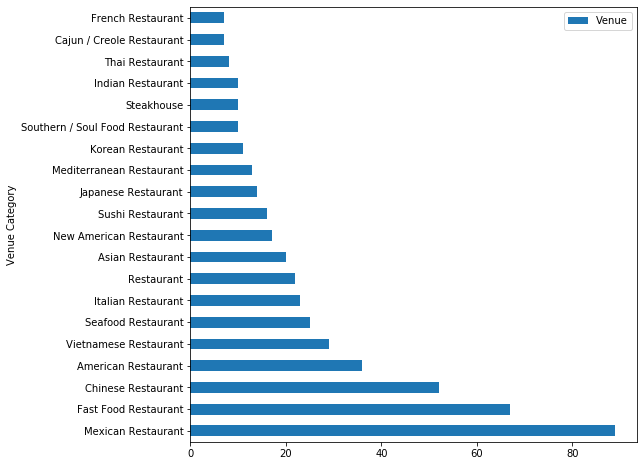

In [62]:
# df.to_csv('houston_restaurant.csv')
df1=df.groupby('Venue Category').count()
df1.sort_values(['Venue'], ascending=0, inplace=True)
df1.drop(columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude'], inplace=True)
df1.iloc[:20].plot.barh(figsize=(8,8))
plt.show()

In [63]:
df_onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")
df_onehot.head()

,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,...,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


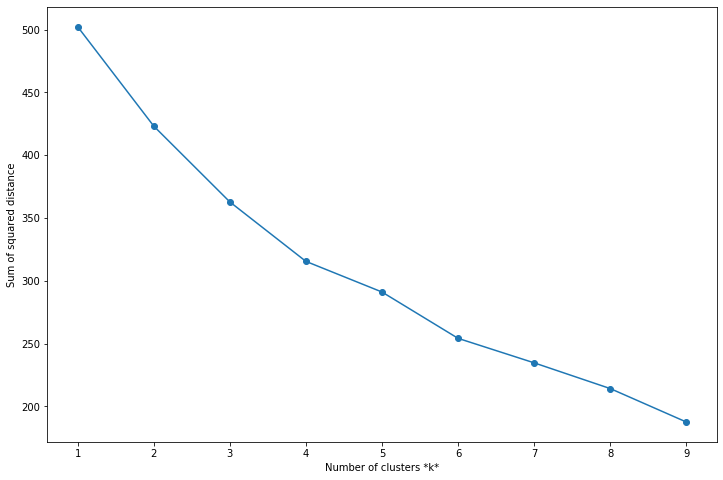

In [74]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df_onehot)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(12, 8))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

**Best k=4**

In [66]:
newdf=pd.DataFrame.merge(df,df_onehot,on=df.index)
newdf=newdf.set_index(['key_0'])
newdf.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Afghan Restaurant,American Restaurant,Argentinian Restaurant,...,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
key_0,,,,,,,,,,,,,,,,,,,,,
1,Fourth,29.918717,-95.516658,Hickory Hollow Restaurant and Catering,29.925428,-95.521963,American Restaurant,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,Second Ward,29.747542,-95.340107,Champ Burger,29.749796,-95.340350,American Restaurant,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12,Second Ward,29.747542,-95.340107,El Tiempo Cantina,29.756222,-95.341484,Mexican Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,Second Ward,29.747542,-95.340107,Villa Arcos,29.755734,-95.339584,Mexican Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,Second Ward,29.747542,-95.340107,Taquerias El Charro Mex,29.746691,-95.338020,Mexican Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_onehot)

kmeans.labels_[0:10]

array([0, 0, 1, 1, 1, 0, 1, 0, 0, 0], dtype=int32)

In [68]:
# add clustering labels
newdf.insert(0, 'Cluster Labels', kmeans.labels_)
newdf.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Afghan Restaurant,American Restaurant,...,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
key_0,,,,,,,,,,,,,,,,,,,,,
1,0,Fourth,29.918717,-95.516658,Hickory Hollow Restaurant and Catering,29.925428,-95.521963,American Restaurant,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,Second Ward,29.747542,-95.340107,Champ Burger,29.749796,-95.340350,American Restaurant,0,1,...,0,0,0,0,0,0,0,0,0,0
12,1,Second Ward,29.747542,-95.340107,El Tiempo Cantina,29.756222,-95.341484,Mexican Restaurant,0,0,...,0,0,0,0,0,0,0,0,0,0
13,1,Second Ward,29.747542,-95.340107,Villa Arcos,29.755734,-95.339584,Mexican Restaurant,0,0,...,0,0,0,0,0,0,0,0,0,0
24,1,Second Ward,29.747542,-95.340107,Taquerias El Charro Mex,29.746691,-95.338020,Mexican Restaurant,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
for i in range(kclusters):
    print('Cluster=',i)
    print(newdf[newdf['Cluster Labels']==i]['Venue Category'].unique())

Cluster= 0
['American Restaurant' 'Sushi Restaurant' 'Italian Restaurant'
 'New American Restaurant' 'Southern / Soul Food Restaurant'
 'Thai Restaurant' 'Empanada Restaurant' 'Greek Restaurant'
 'Latin American Restaurant' 'Theme Restaurant' 'Japanese Restaurant'
 'Steakhouse' 'Seafood Restaurant' 'Mediterranean Restaurant'
 'French Restaurant' 'Comfort Food Restaurant' 'Restaurant'
 'Cajun / Creole Restaurant' 'Vietnamese Restaurant' 'Asian Restaurant'
 'Indian Chinese Restaurant' 'Noodle House' 'Persian Restaurant'
 'Tapas Restaurant' 'Indian Restaurant' 'Caribbean Restaurant'
 'Hotpot Restaurant' 'Afghan Restaurant' 'Spanish Restaurant'
 'Hawaiian Restaurant' 'Argentinian Restaurant' 'Korean Restaurant'
 'Brazilian Restaurant' 'Vegetarian / Vegan Restaurant'
 'Middle Eastern Restaurant' 'Modern European Restaurant'
 'Ramen Restaurant' 'Dumpling Restaurant' 'Cuban Restaurant'
 'Turkish Restaurant' 'Dim Sum Restaurant' 'Malay Restaurant'
 'Taiwanese Restaurant']
Cluster= 1
['Mexican 

In [70]:
# create map
map_clusters = folium.Map(location=[lat_Houston, lon_Houston], zoom_start=10)

colors=['orange','red','blue','green','purple','darkred','lightred','beige','darkblue','darkgreen','cadetblue','darkpurple','white','pink','lightblue','lightgreen','gray','black','lightgray']

# add markers to the map
markers_colors = []
for lat, lon, venue, category, cluster in zip(newdf['Venue Latitude'], newdf['Venue Longitude'], newdf['Venue'], newdf['Venue Category'], newdf['Cluster Labels']):
    label = folium.Popup(venue + '-' + category + ' Cluster ' + str(cluster), parse_html=True)
    
    if pop>10000:
        r=5
    else:
        r=4
    
    if cluster!=0:
        folium.CircleMarker(
            [lat, lon],
            radius=r,
            popup=label,
            color=colors[int(cluster)],  #rainbow[int(cluster)-1],
            fill=True,
            fill_color=colors[int(cluster)], #rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_clusters)

map_clusters

  ## References <a name="ref"></a>

[1] https://en.wikipedia.org/wiki/Houston <a name="1"></a>  
[2] https://cohgis-mycity.opendata.arcgis.com/ <a name="2"></a>  
[3] http://www.houstontx.gov <a name="3"></a>  
[4] https://foursquare.com <a name="4"></a>  

## Supplemental Material <a name="supp"></a>

In order to make better typesetting, I use the libary "_IPython.core.display_", which may not work in github. Please use "_nbviewer_" for this report in the following link:  
https://nbviewer.jupyter.org/github/phyhuhu/Coursera_Capstone/blob/master/Capstone_week5.ipynb

In [75]:
# code for the typesetting:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:0.2em;
margin-bottom:0.2em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}

div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.5em;
line-height:1.0em;
padding-left:2em;
padding-right:2em;
}

</style>
""")